# Hierarchical Photo-z's on Mock HSC Data

Part 5 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook applies the results from Part 4 (run over mock SDSS data) and applies them to mock HSC data.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

Let's import our mock HSC data.

In [2]:
hsc = pickle.load(open( "data/mock_hsc_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = hsc.samples, hsc.samples_t # import truth labels

Let's now initialize our catalogs and compute our fits.

In [3]:
# dividing into training/testing samples
Nobs = hsc.NSAMPLES
Ntrain, Ntest = 100000, 20000

mcut = 26
fcut = 10**(-0.4*(mcut-23.9))
sel_train = arange(Nobs)[hsc.phot_obs[:,2] > fcut] # i-mag < 26
train_sel = sel_train[:Ntrain] # training set
Ntrain = len(train_sel)

mcut = 24.5
fcut = 10**(-0.4*(mcut-23.9))
sel_test = arange(Nobs)[hsc.phot_obs[:,2] > fcut] # i-mag < 24.5
test_sel = sel_test[sel_test>train_sel[-1]][:Ntest] # testing set
Ntest =  len(test_sel)

print 'Number of observed galaxies (all):', Nobs
print 'Number of training galaxies:', Ntrain
print 'Number of testing galaxies:', Ntest

Number of observed galaxies (all): 500000
Number of training galaxies: 100000
Number of testing galaxies: 20000


In [4]:
# initializing photometry
phot_train, phot_test = hsc.phot_obs[train_sel], hsc.phot_obs[test_sel]
err_train, err_test = hsc.noise[train_sel], hsc.noise[test_sel]
pkern = ones(hsc.NFILTER)*0.05 # photometric Gaussian kernel (smoothing)
err_train = sqrt(err_train**2 + (pkern*phot_train)**2) # add kernel to training objects

# initializing masks
mask = random.uniform(size=(Ntrain+Ntest, hsc.NFILTER)) > 0.01 # randomly censor 5% of observations
mask[:,2] = True # always detected in r-band (used for selection)
mask_train, mask_test = mask[:Ntrain], mask[Ntrain:Ntrain+Ntest]

csel_train, csel_test = mask_train.sum(axis=1) < hsc.NFILTER, mask_test.sum(axis=1) < hsc.NFILTER

print 'Number of censored training objects:', csel_train.sum()
print 'Number of censored testing objects:', csel_test.sum()

Number of censored training objects: 3919
Number of censored testing objects: 792


In [5]:
# initialize asinh magnitudes (Luptitudes)
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint
mag, magerr = fz.asinh_mag_map(hsc.phot_obs, hsc.noise, # map f_nu to asinh mag
                               skynoise=hsc.FDEPTHS, zeropoints=flux_zeropoint) # softening parameter and zero-point

# read FRANKEN-Z config files (to get dictionaries)
config = fz.ReadParams('config/frankenz.config')

# initialize supplementary dictionaries
mdict = fz.PDFDict(config.CONFIG_MAG.params) # magnitude dict
cdict = fz.PDFDict(config.CONFIG_COLOR.params) # color dict
magidx, mageidx = mdict.fit(mag, magerr) # discretized magnitudes

In [6]:
# initialize redshift dictionary
rdict = fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict = rdict.lze_dict
rdict.sig_width = rdict.lze_width
rdict.delta = rdict.dlz_highres
rdict.grid = rdict.lzgrid_highres
rdict.Ngrid = rdict.Nz_highres

# discretize redshifts
lz, lze = log(1+redshifts), ones(Nobs)*rdict.dlz 
lzidx, lzeidx = rdict.fit(lz, lze) # discretized ln(1+z)
lz_train, lze_train = lz[train_sel], lze[train_sel]

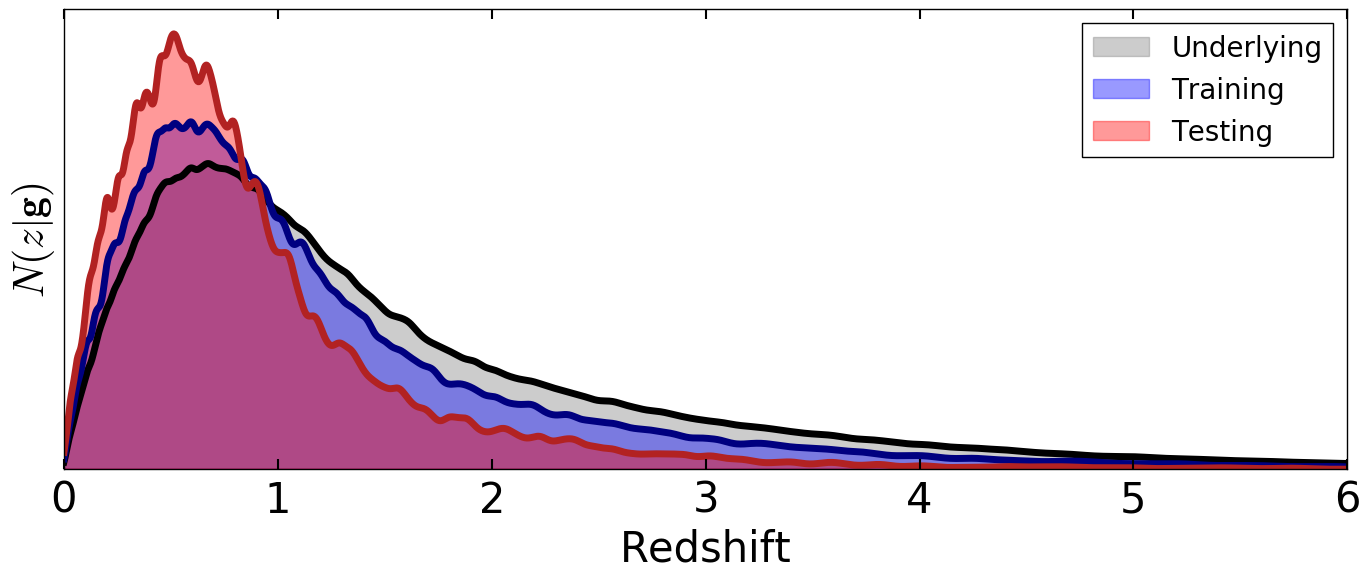

In [7]:
# plotting redshift distribution
figure(figsize=(14,6))

# all
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, ones(Nobs),
                       rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black')
fill_between(rdict.zgrid_highres, z_pdf, color='gray', alpha=0.4, label='Underlying')

# training
z_pdf_train = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], ones(Ntrain),
                              rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf_train = z_pdf_train[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf_train /= z_pdf_train.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf_train, lw=5, color='navy')
fill_between(rdict.zgrid_highres, z_pdf_train, color='blue', alpha=0.4, label='Training')

# testing
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel], lzeidx[test_sel], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='firebrick')
fill_between(rdict.zgrid_highres, z_pdf, color='red', alpha=0.4, label='Testing')

xlim([0, 6])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')

## Posteriors

In [8]:
# initialize FRANKEN-Z instance
frankenz = fz.FRANKENZ(N_members=25, n_neighbors=10)

# initialize WINBET instance (training)
winbet_train = fz.WINBET(Ntrees=25) # 25 trees
winbet_train.train(phot_train, err_train, mask_train)

# initialize WINBET instance (testing)
winbet_test = fz.WINBET(Ntrees=25) # 25 trees
winbet_test.train(phot_test, err_test, mask_test)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [9]:
# compute log-likelihoods
model_obj, model_Nobj, model_ll, model_Nbands = frankenz.predict(phot_train, err_train, mask_train, 
                                                                 phot_test, err_test, mask_test, 
                                                                 impute_train=winbet_train, impute_targ=winbet_test)

(0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) (20) (21) (22) (23) (24) 0 5000 10000 15000 done!


In [10]:
# compute selection probability
model_psel = model_ll.copy()
for i in arange(Ntest):
    if i%5000 == 0: sys.stdout.write(str(i)+' ')
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    
    # training/testing photometry
    ptrain, etrain = phot_train[midx,2], err_train[midx,2]
    ptest, etest = phot_test[i,2], err_test[i,2]
    
    # computing prob
    mu = ptrain
    x = max(10*etest, fcut)
    sigma = sqrt(square(etrain) + square(etest))
    model_psel[i,:Nm] = 1 - 0.5 * special.erfc((mu-x) / (sqrt(2)*sigma))

0 5000 10000 15000 

In [11]:
# compute posteriors
model_post = zeros(model_ll.shape)
model_evid = zeros(Ntest)

for i in arange(Ntest):
    Nm = model_Nobj[i] # number of models
    midx = model_obj[i,:Nm] # model indices
    ll = model_ll[i,:Nm] # log-likelihoods
    like = exp(-0.5*(ll-ll.min())) # scaled likelihoods
    model_evid[i] = like.sum() * exp(-0.5*ll.min())
    post = float64(like * model_psel[i,:Nm]) # scaled posteriors
    post /= post.sum() # normalizing
    model_post[i,:Nm] = post

Let's check our coverage.

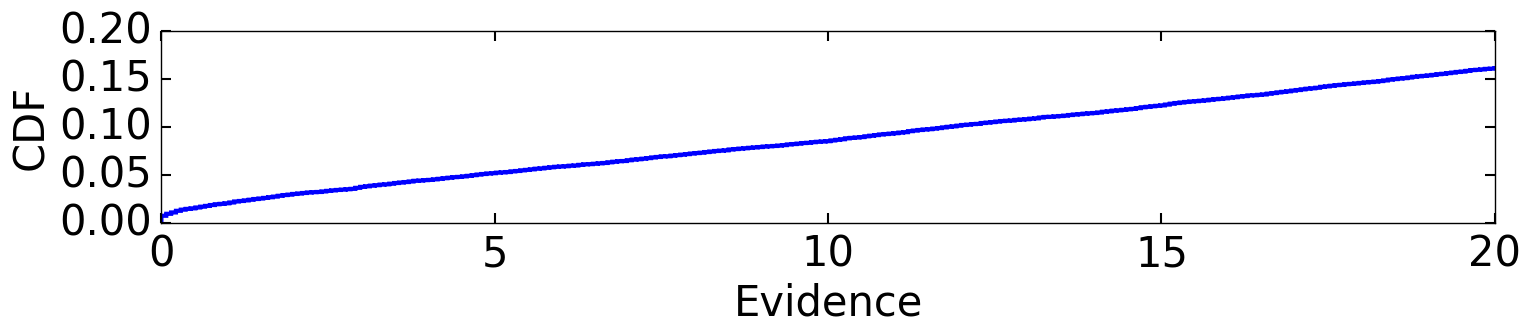

In [12]:
figure(figsize=(16,4))
h = hist(model_evid, 10000, histtype='step', lw=3, normed=True, cumulative=True)
xlabel('Evidence')
xlim([0,20])
ylabel('CDF')
ylim([0,0.2])
tight_layout()

In [13]:
pmask = arange(Ntest)[model_evid>10]
Ntest = len(pmask)
print('Objects with reasonable coverage {:}/{:}'.format(Ntest, len(model_evid)))

Objects with reasonable coverage 18300/20000


In [14]:
# computing stacked posteriors
pstack = zeros(Ntrain)
for i in pmask:
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    pstack[midx] += model_post[i,:Nm] # stacked posterior

In [15]:
# compute redshift PDF (truth)
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel][pmask], lzeidx[test_sel][pmask], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf = interp(rdict.zgrid_out, rdict.zgrid_highres, z_pdf)
z_pdf /= z_pdf.sum() # normalizing

# compute redshift PDF (stacked)
z_trn = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], pstack,
                        rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_trn = z_trn[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_trn = interp(rdict.zgrid_out, rdict.zgrid_highres, z_trn)
z_trn /= z_trn.sum() # normalizing

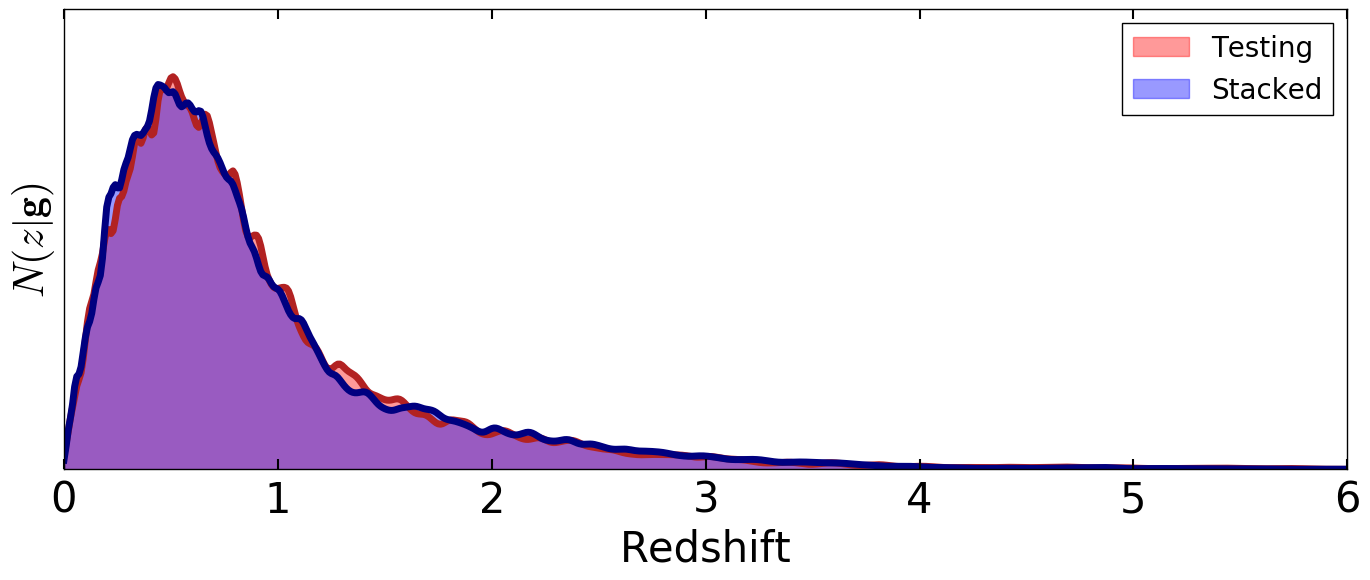

In [16]:
# plotting redshift distribution
figure(figsize=(14,6))

# testing
plot(rdict.zgrid_out, z_pdf, lw=5, color='firebrick')
fill_between(rdict.zgrid_out, z_pdf, color='red', alpha=0.4, label='Testing')

# training
plot(rdict.zgrid_out, z_trn, lw=5, color='navy')
fill_between(rdict.zgrid_out, z_trn, color='blue', alpha=0.4, label='Stacked')

xlim([0, 6])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')

## Population Inference: Posterior

In [17]:
Nsamples = 20 # number of samples

In [18]:
post_samples = zeros((Nsamples, Ntrain), dtype='int')
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm]
        post_samples[i,midx] += multinomial(1, post) # sample object

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

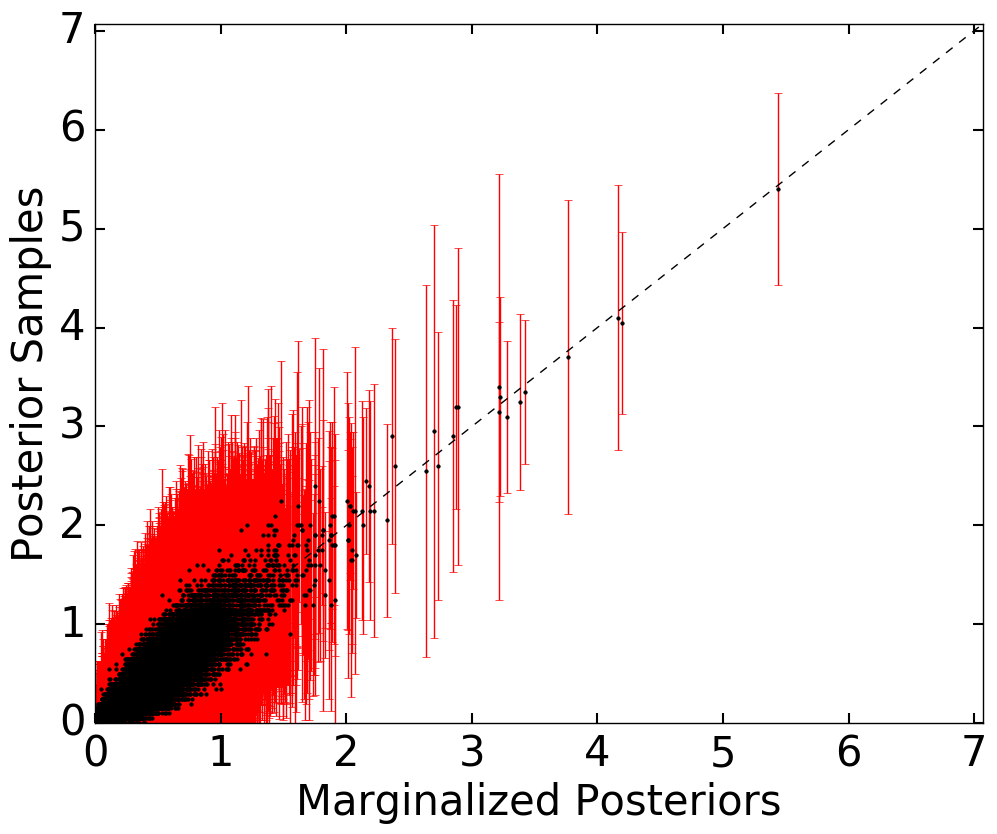

In [19]:
# plotting
figure(figsize=(20,9))
subplot(1,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), ecolor='red', markersize=5, lw=1)
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Posterior Samples')
tight_layout()

In [23]:
# draw redshift samples
post_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], post_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    post_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    post_samples_z[i] *= (Ntest / post_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

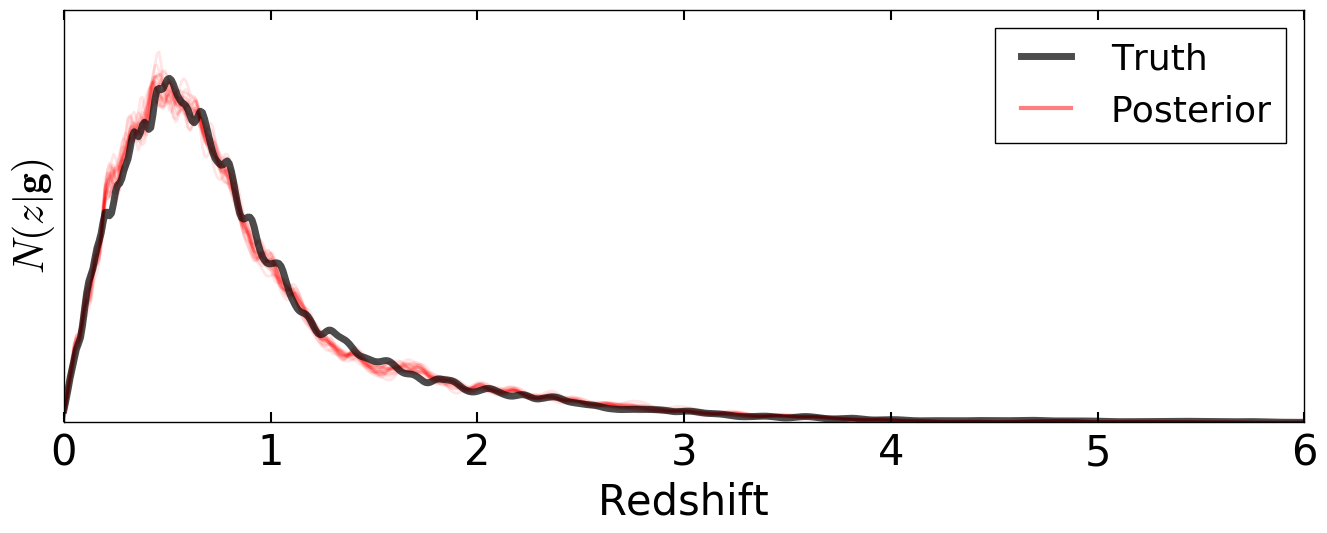

In [24]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, post_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

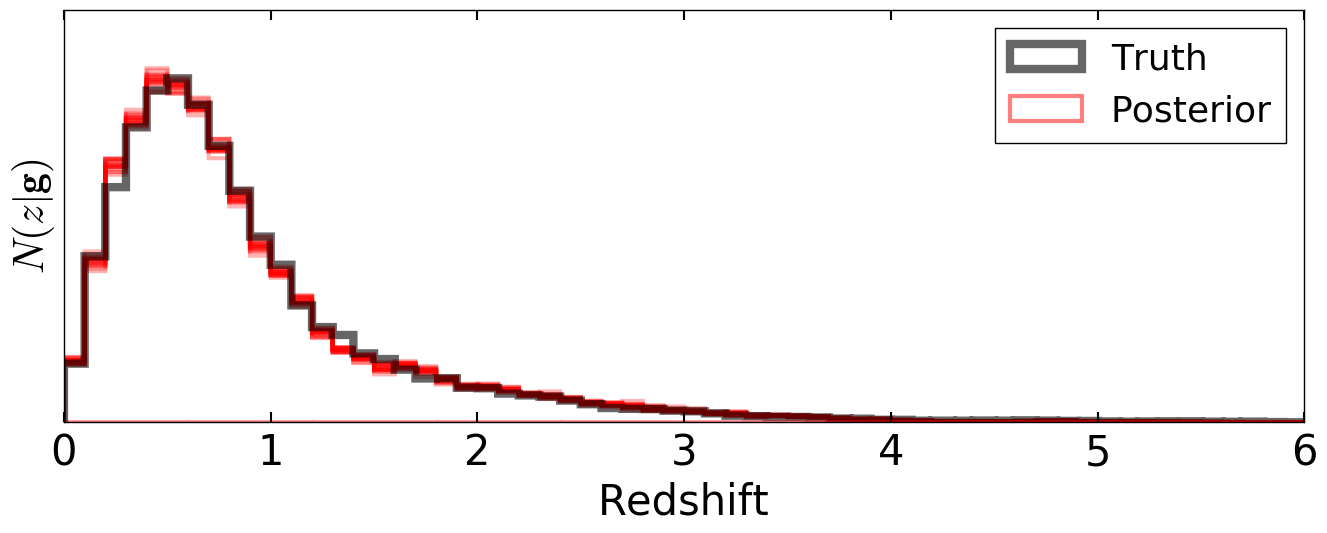

In [25]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=post_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
yticks([])
ylim([0, max(h[0]) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

## Hierarchical Inference

In [26]:
# generate samples
Nmcmc = 200 # total number of MCMC draws
hier_samples_n = zeros((Nmcmc, Ntrain))
hier_samples_w = zeros((Nmcmc, Ntrain))

wt = ones(Ntrain) # initialize weights
for i in xrange(Nmcmc):
    sys.stdout.write(str(i)+' ')
    n = zeros(Ntrain) # number counts
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm] * wt[midx]
        post /= post.sum()
        n[midx] += multinomial(1, post) # stack multinomial draw
    wt = dirichlet(n + 1) * Ntest # sample population weight
    hier_samples_n[i], hier_samples_w[i] = n.copy(), wt.copy()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

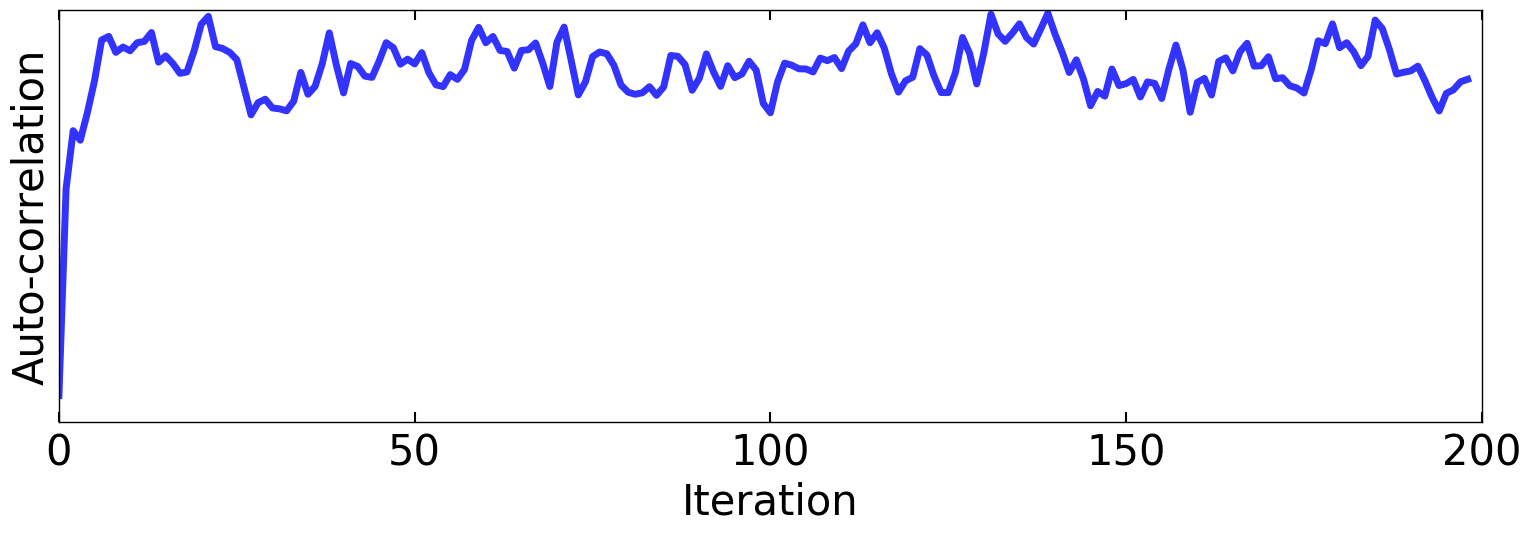

In [27]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(hier_samples_n[i], hier_samples_n[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8, label='Original')
xlabel('Iteration')
ylabel('Auto-correlation')
yticks([])
xlim([0, Nmcmc])
tight_layout()

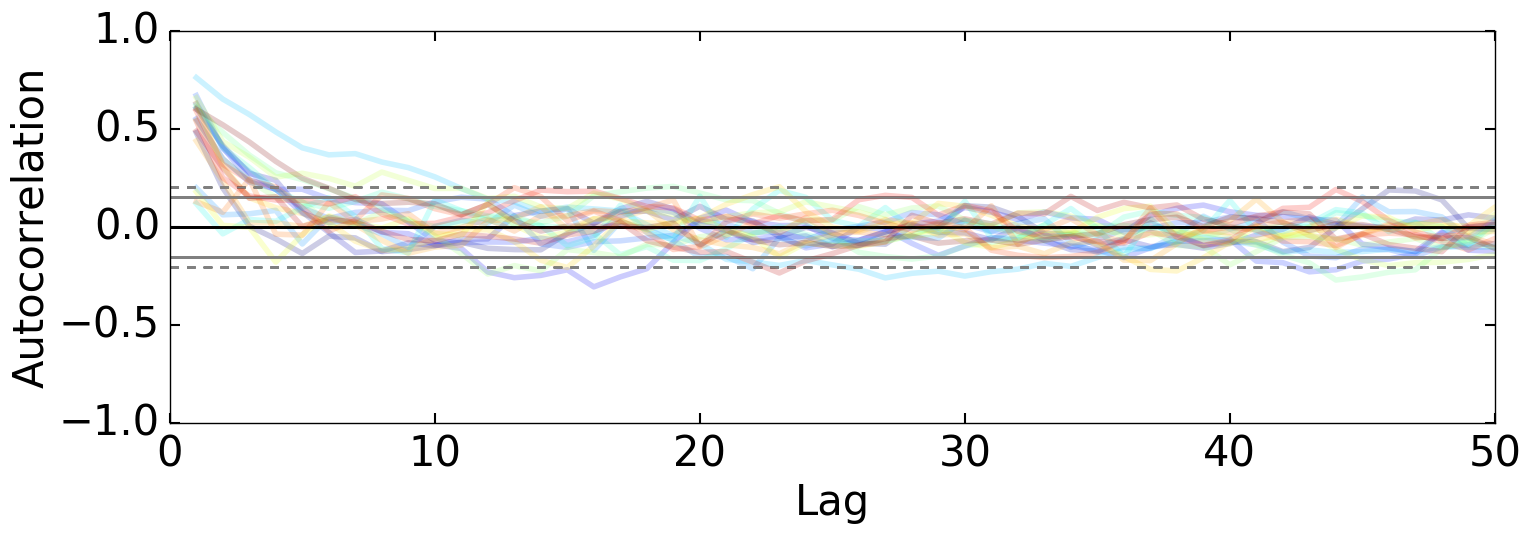

In [28]:
Nburnin = 40 # burn-in
indices = argsort(hier_samples_w[Nburnin:].mean(axis=0))[::-1] # sort from largest to smallest weights

# plot autocorrelation lag
figure(figsize=(16,6))
colors = get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(hier_samples_w[Nburnin:,indices[i]], color=colors[i], lw=4, alpha=0.2) for i in xrange(20)]
xlim([0, 50])
tight_layout()

Let's look at the traces of a few samples.

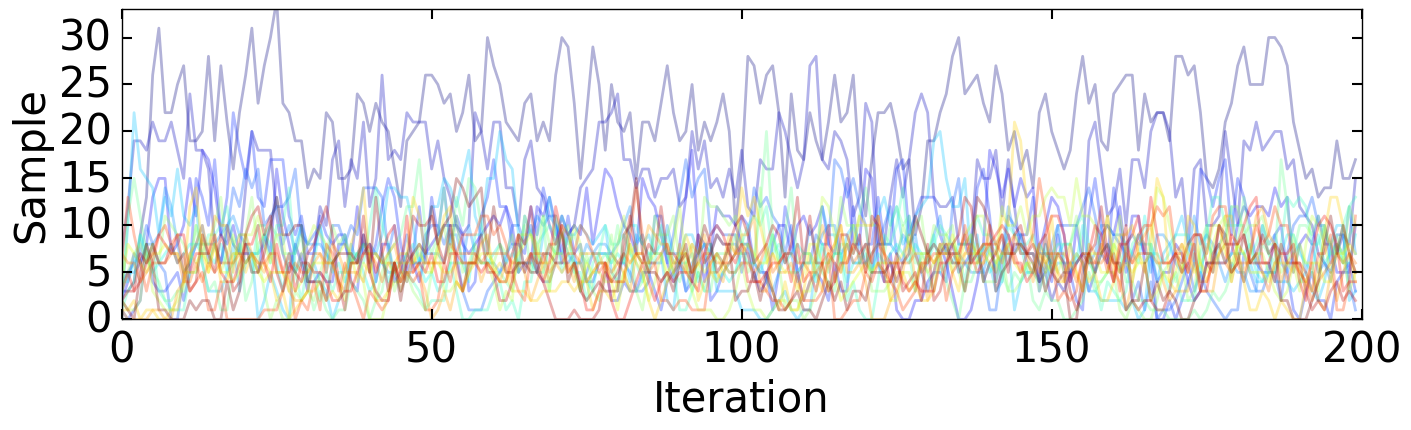

In [29]:
# plot samples
figure(figsize=(16,4))
for i in xrange(20):
    idx = indices[i]
    plot(arange(Nmcmc), hier_samples_n[:,idx], color=colors[i], lw=2, alpha=0.3)
ylim([max(0,hier_samples_n[Nburnin:,indices[:20]].min()-100), hier_samples_n[Nburnin:,indices[:20]].max()*1.1])
xlim([0, Nmcmc])
xlabel('Iteration')
ylabel('Sample')

In [30]:
# thinning
Nthin = 8
hier_samples_t = hier_samples_n[Nburnin::Nthin]

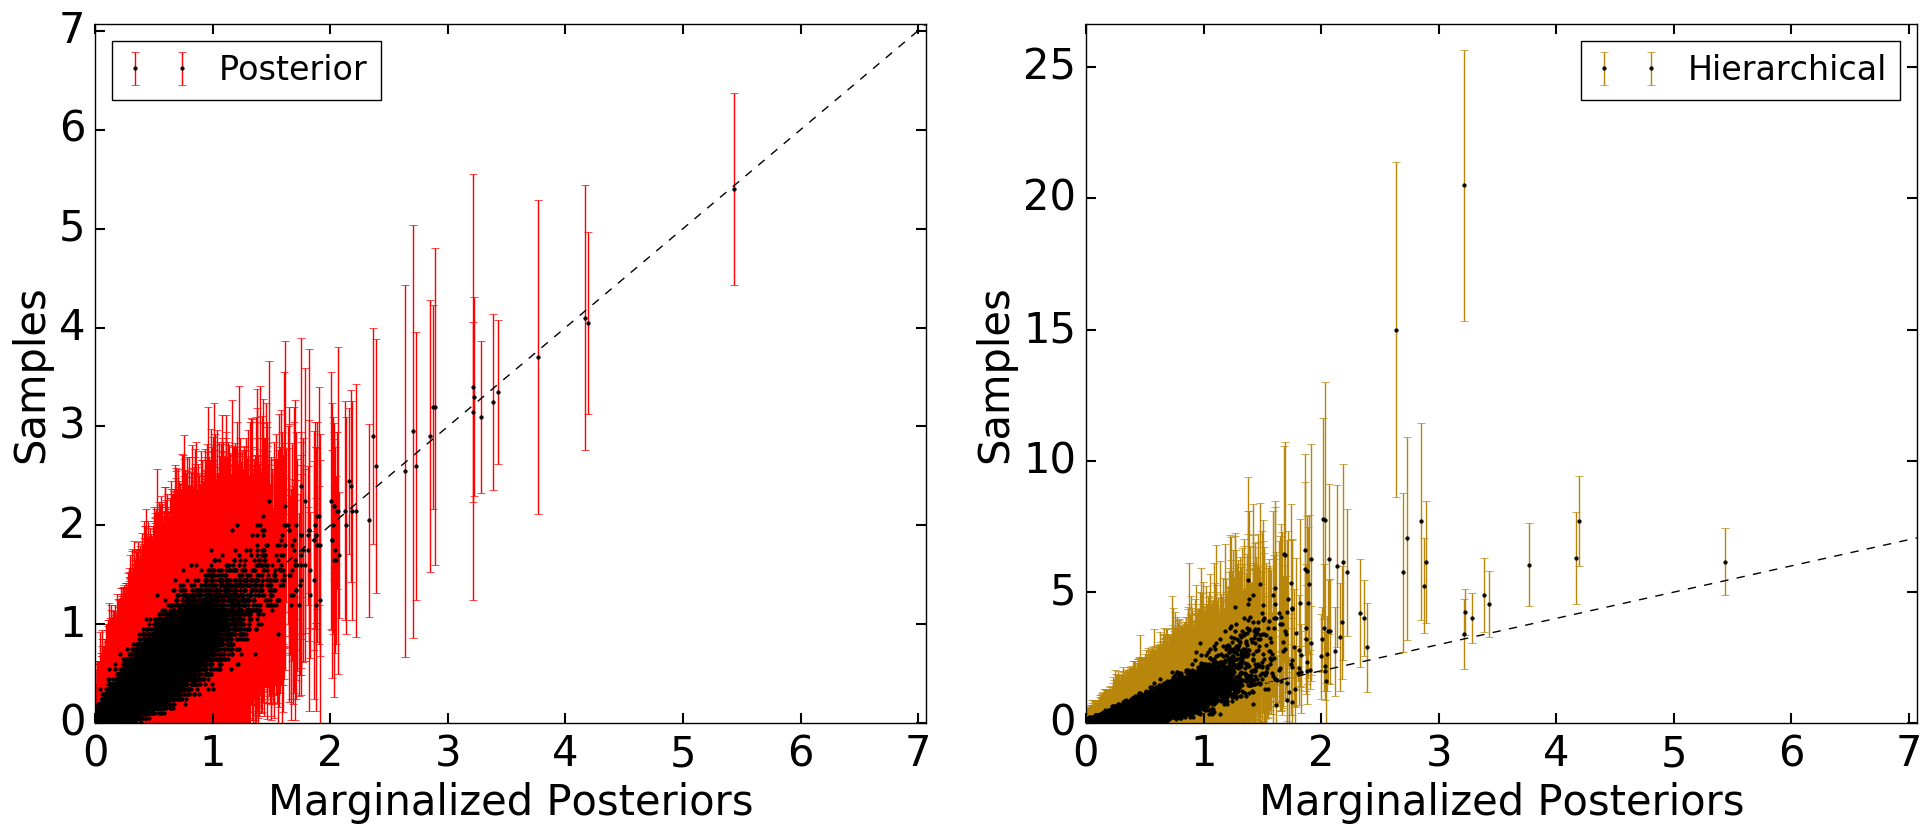

In [31]:
# plotting
figure(figsize=(20,9))
subplot(1,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), 
         ecolor='red', markersize=5, lw=1, label='Posterior')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(1,2,2)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, hier_samples_t.mean(axis=0), fmt='k.', yerr=hier_samples_t.std(axis=0), 
         ecolor='darkgoldenrod', markersize=5, lw=1,
         label='Hierarchical')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, hier_samples_t.mean(axis=0).max()*1.3])
ylabel('Samples')
legend(loc=1, fontsize=24)
tight_layout()

In [32]:
# draw redshift samples
hier_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], hier_samples_t[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    hier_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    hier_samples_z[i] *= (Ntest / hier_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

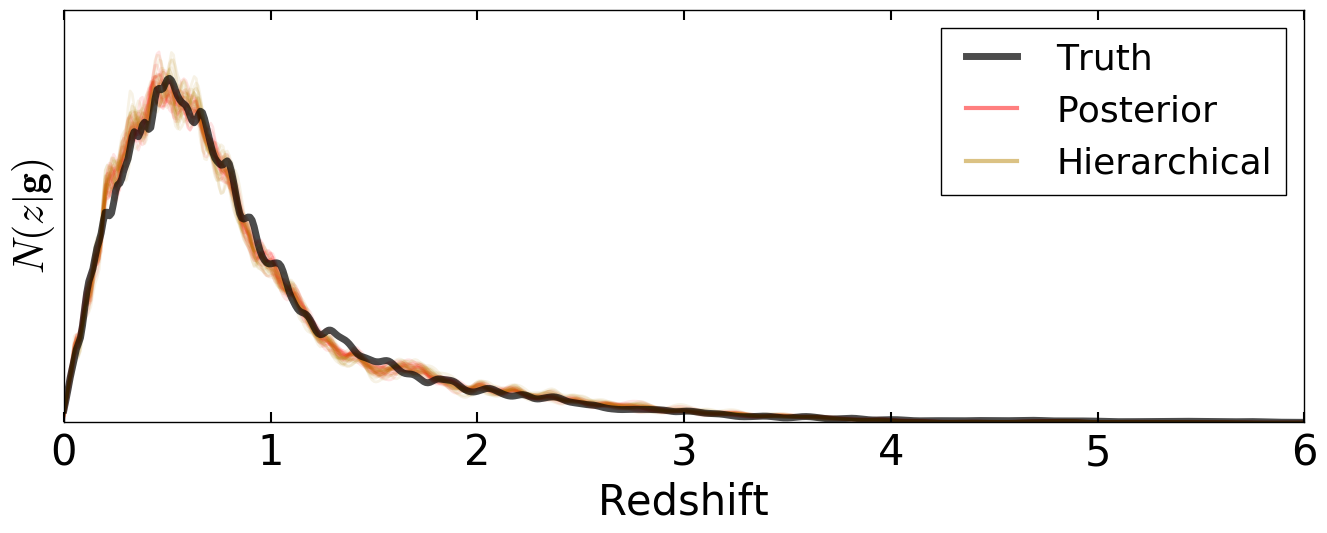

In [33]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, post_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, hier_samples_z[i], lw=2, color='darkgoldenrod', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

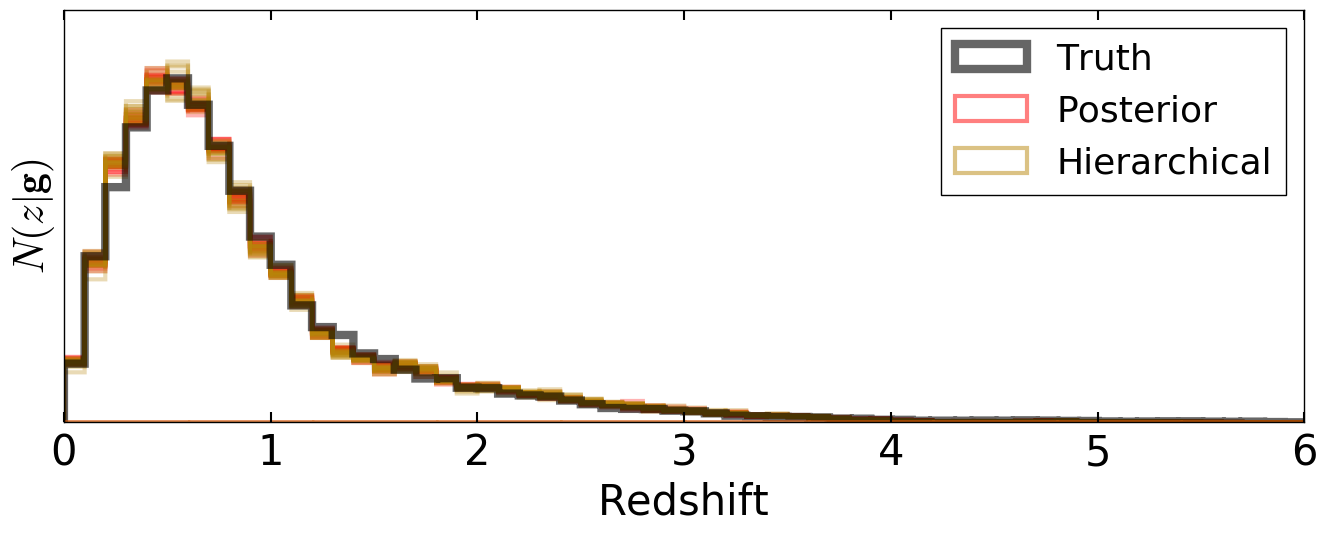

In [34]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=post_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=hier_samples_z[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
xlim([zgrid.min(), zgrid.max()])
yticks([])
ylim([0, max(h[0]) * 1.2])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

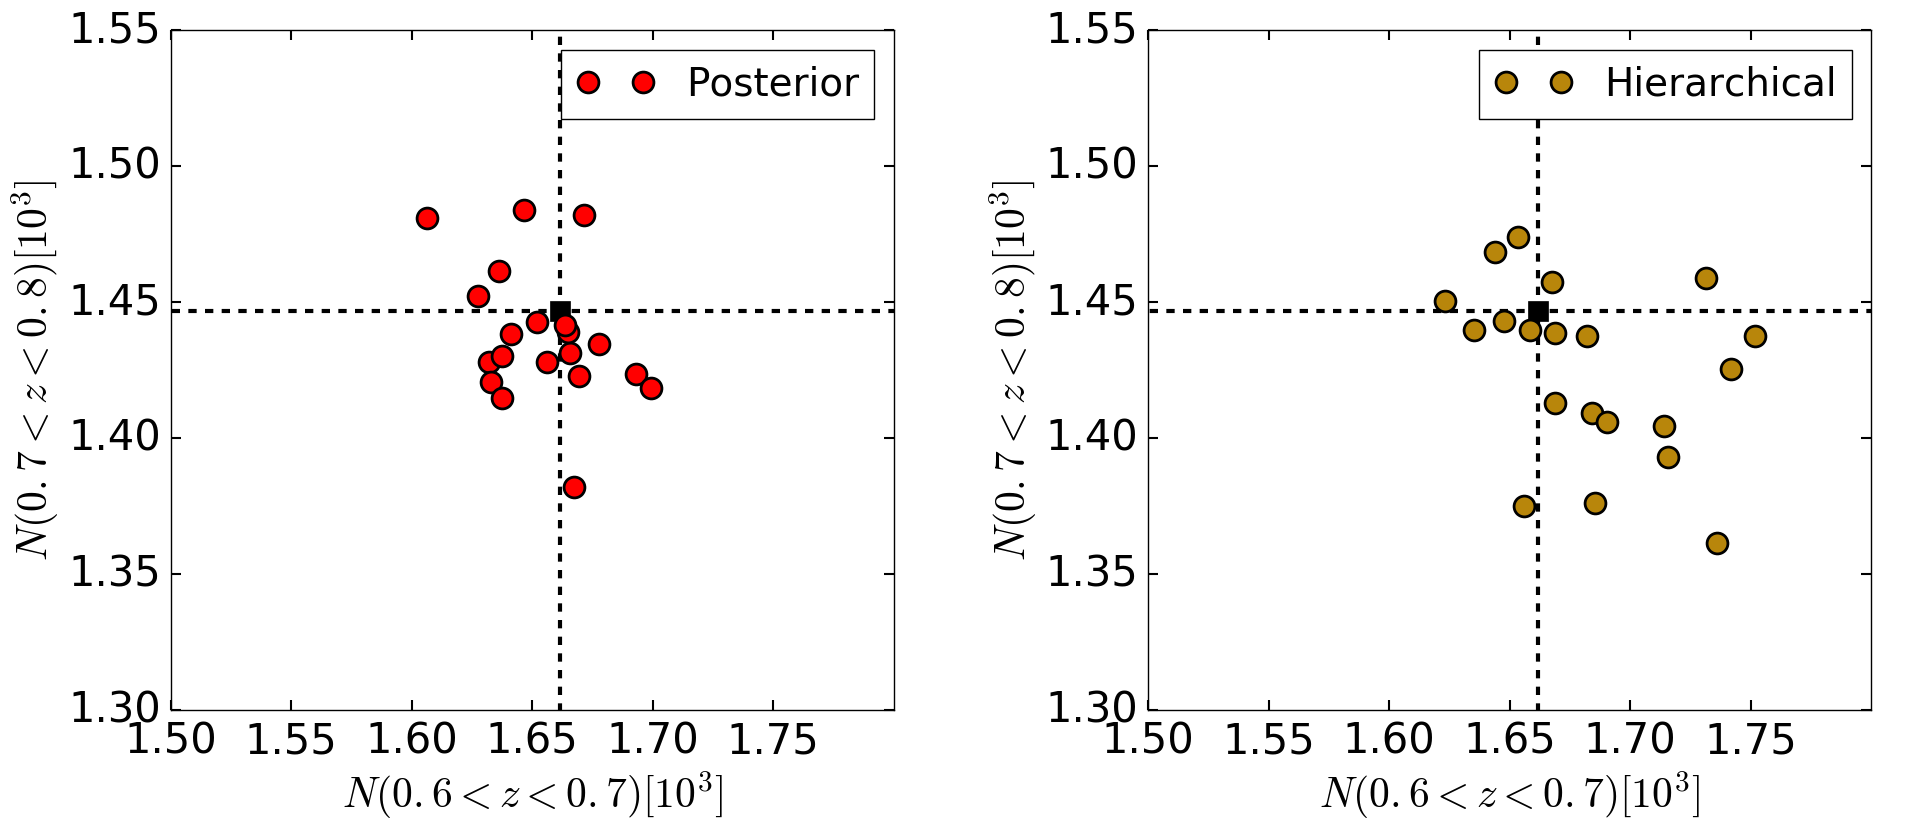

In [35]:
figure(figsize=(20,9))
subplot(1,2,1)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(post_samples_z[:,60:70].sum(axis=1)/1e3, post_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='red', 
     label='Posterior', markersize=15, markeredgewidth=2)
ylim([1.3, 1.55])
xlim([1.5, 1.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(1,2,2)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(hier_samples_z[:,60:70].sum(axis=1)/1e3, hier_samples_z[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=15, markeredgewidth=2)
ylim([1.3, 1.55])
xlim([1.5, 1.8])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()